# Базовые алгоритмы машинного обучения. Задача классификации.
# Метод: Логистическая регрессия

## Задание

1. Разработать программу реализующую алгоритм логистической регрессии для анализа выбранного набора данных.
2. Визуализировать используемый набор данных и работу алгоритма.
3. Построить график зависимости качества классификации от регуляризации и полиномизации.
4. Провести анализ зависимости качества классификации от регуляризации и полиномизации.
5. Подобрать параметры алгоритма так, чтобы получить наилучшее качество модели на тестовых данных.

# Логистическая регрессия

Линейный классификатор

Основная идея линейного классификатора заключается в том, что признаковое пространство может быть разделено гиперплоскостью на два полупространства, в каждом из которых прогнозируется одно из двух значений целевого класса. Если это можно сделать без ошибок, то обучающая выборка называется <u>линейно разделимой</u>.

**Логистическая регрессия как линейный классификатор**

Логистическая регрессия является частным случаем линейного классификатора, но она обладает хорошим "умением" – прогнозировать вероятность $p_+$ отнесения примера $\vec{x_i}$ к классу "+":
$$\large p_+ = P\left(y_i = 1 \mid \vec{x_i}, \vec{w}\right) $$
Прогнозирование не просто ответа ("+1" или "-1"), а именно вероятности отнесения к классу "+1" во многих задачах является очень важным бизнес-требованием.

# Для улучшения качества работы модели подберем наилучшее значение гиперпараметра  (регуляризация).

Гиперпараметр `C` отвечает за регуляризацию.<br>
Особенности этого параметра заключаются в следующем: 
- чем больше параметр $C$, тем более сложные зависимости в данных может восстанавливать модель (интуитивно $C$ соответствует "сложности" модели (model capacity));
- если регуляризация слишком сильная (малые значения $C$), то решением задачи минимизации логистической функции потерь может оказаться то, когда многие веса занулились или стали слишком малыми. Еще говорят, что модель недостаточно "штрафуется" за ошибки. В таком случае модель окажется <u>недообученной</u>;
- наоборот, если регуляризация слишком слабая (большие значения $C$), то вольно выражаясь, модель слишком "боится" ошибиться на объектах обучающей выборки, поэтому окажется <u>переобученной</u>.

Также попытаемся улучшить качество работы модели с помощью полиномиальных признаков, которые позволяют линейным моделям строить нелинейные разделяющие поверхности. 

[Больше информации можно получить здесь.](https://habr.com/ru/company/ods/blog/323890/)

## Подключение необходимых библиотек

`%matplotlib inline` -> визуализирует графики с matplotlib прямо в jupyter notebook, а не в отдельном окне

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs

# Определим функцию, которая будет отображать нашу кривую классификатора

In [2]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

## Набор данных 1

In [3]:
X, y = make_moons(n_samples=2000, noise=0.3, random_state=0)

### Разделим данные на обучающую и тестовую выборку
Параметры train_test_split:
- test_size -> указывает какой % данных пойдет на тестовую выборку;
- random_state -> отвечает за перемешивание данных (параметр = 0 гарантирует воспроизводимость результата).

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#### Изобразим данные на графике

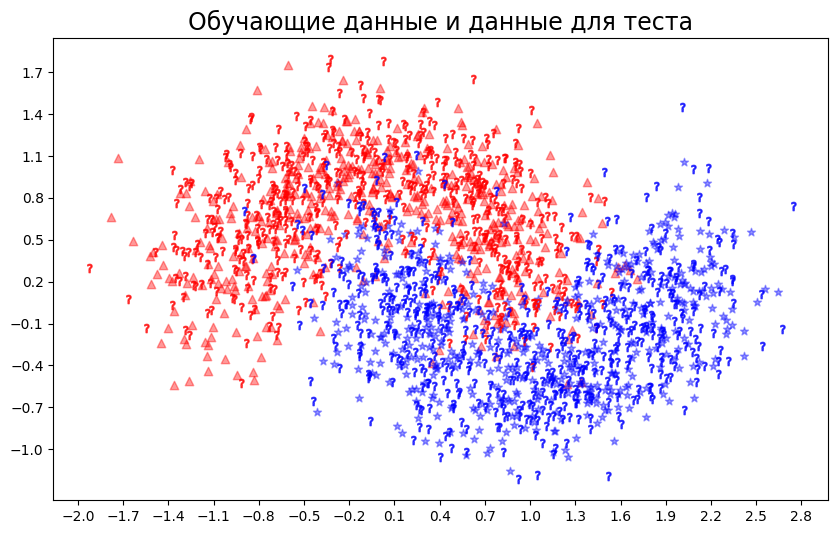

In [5]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Тестовая выборка - знаки вопроса

ax.scatter(x_test[y_test==0,0],x_test[y_test==0,1], color="r", marker="$?$", alpha=0.7)
ax.scatter(x_test[y_test==1,0],x_test[y_test==1,1], color="b", marker="$?$", alpha=0.7)

ax.set_title("Обучающие данные и данные для теста", fontsize=17)

ax.set_xticks(np.arange(-2, 3, 0.3))
ax.set_yticks(np.arange(-1, 2, 0.3))

plt.show()

### Реализуем метод логистической регрессии для набора данных №1

#### Реализуем метод без гиперпараметров

In [6]:
poly = PolynomialFeatures(degree=1) # Линейная модель
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=1) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 0.83
Точность работы модели (model_logical_reg.score) = 0.83


#### Изобразим результат работы алгоритма на графике

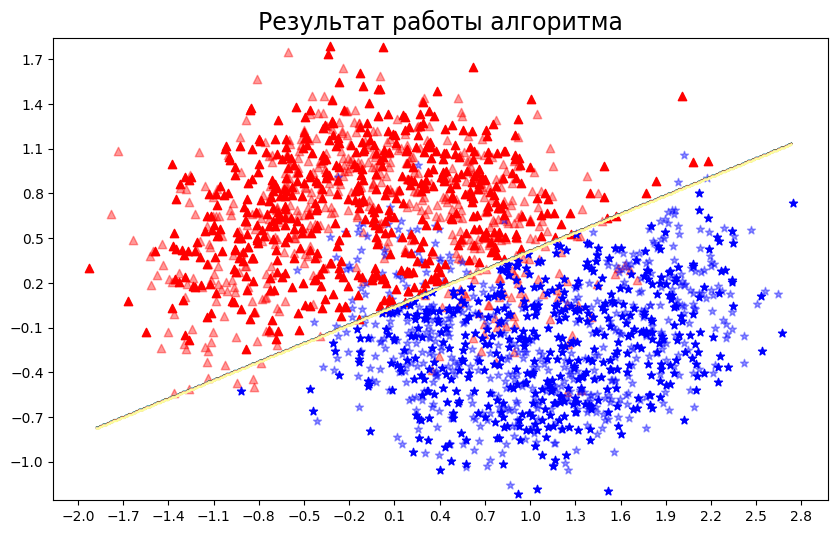

In [7]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01 ,poly_featurizer=poly)

ax.set_title("Результат работы алгоритма", fontsize=17)

ax.set_xticks(np.arange(-2, 3, 0.3))
ax.set_yticks(np.arange(-1, 2, 0.3))

plt.show()

**Для данной тестовой выборки неплохо подходит линейная логистическая регрессия, но все же наши данные нельзя назвать линейно разделимыми, поэтому попробуем увеличить точность предсказания, с помощью задания полиномизации (полиномизация позволит построить нелинейные разделяющие поверхности, которые могут более точно описывать наши данные) и изменения гиперпараметра регуляризации логистической регрессии.**

#### Поиск наилучших параметров для метода

In [8]:
%time
value_accuracy_score_array = [[],[],[],[],[]] 

degree_poly = list(range(2,11)) # Степень полиномизации
c = [0.01, 0.1, 1, 10, 100] # Значение регуляризации

#value_accuracy_score_array[0] - c="0.01"
#value_accuracy_score_array[1] - c="0.1"
#value_accuracy_score_array[2] - c="1"
#...

#value_accuracy_score_array[0][0] - c="0.01", degree_poly = 2
#value_accuracy_score_array[0][1] - c="0.01", degree_poly = 3
#...
#value_accuracy_score_array[1][0] - c="0.1", degree_poly = 2
#value_accuracy_score_array[1][1] - c="0.1", degree_poly = 3
#...
#value_accuracy_score_array[2][0] - c="1", degree_poly = 2
#value_accuracy_score_array[2][1] - c="1", degree_poly = 3
#...

#Индексы используются для записи в value_accuracy_score_array
index_degree_polynomial = 0
index_regularization = 0

for i in c:
    index_degree_polynomial = 0
    
    for j in degree_poly:   
        poly = PolynomialFeatures(degree=j)
        x_poly_train = poly.fit_transform(x_train)
        x_poly_test = poly.fit_transform(x_test)
        
        model_logical_reg = LogisticRegression(C=i, max_iter=3000) # C = 1.0 (default=1.0)
        model_logical_reg.fit(x_poly_train, y_train)
        y_pred = model_logical_reg.predict(x_poly_test)

        value_accuracy_score=accuracy_score(y_test, y_pred)
        value_accuracy_score_array[index_regularization].append(value_accuracy_score)
        index_degree_polynomial+=1
        
    print("iteration ("+ str(index_regularization)+ "\\4)")
    index_regularization+=1  
        
print("\nc=0.01, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[0],"\n")
print("c=0.1, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[1],"\n")
print("c=1, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[2],"\n")
print("c=10, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[3],"\n")
print("c=100, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[4])

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.67 µs
iteration (0\4)
iteration (1\4)
iteration (2\4)
iteration (3\4)
iteration (4\4)

c=0.01, degree_poly=[2..10] -> score:
 [0.791, 0.806, 0.808, 0.842, 0.845, 0.859, 0.859, 0.857, 0.862] 

c=0.1, degree_poly=[2..10] -> score:
 [0.827, 0.88, 0.888, 0.896, 0.898, 0.897, 0.898, 0.897, 0.897] 

c=1, degree_poly=[2..10] -> score:
 [0.833, 0.899, 0.904, 0.907, 0.906, 0.907, 0.909, 0.906, 0.908] 

c=10, degree_poly=[2..10] -> score:
 [0.834, 0.907, 0.91, 0.908, 0.91, 0.909, 0.907, 0.91, 0.909] 

c=100, degree_poly=[2..10] -> score:
 [0.834, 0.908, 0.91, 0.909, 0.907, 0.91, 0.91, 0.912, 0.914]


Изобразим полученный результат точности работы модели на графике, чтобы определить с каким значением параметра `c` и `степени полиномизации` модель дает наилучший результат.

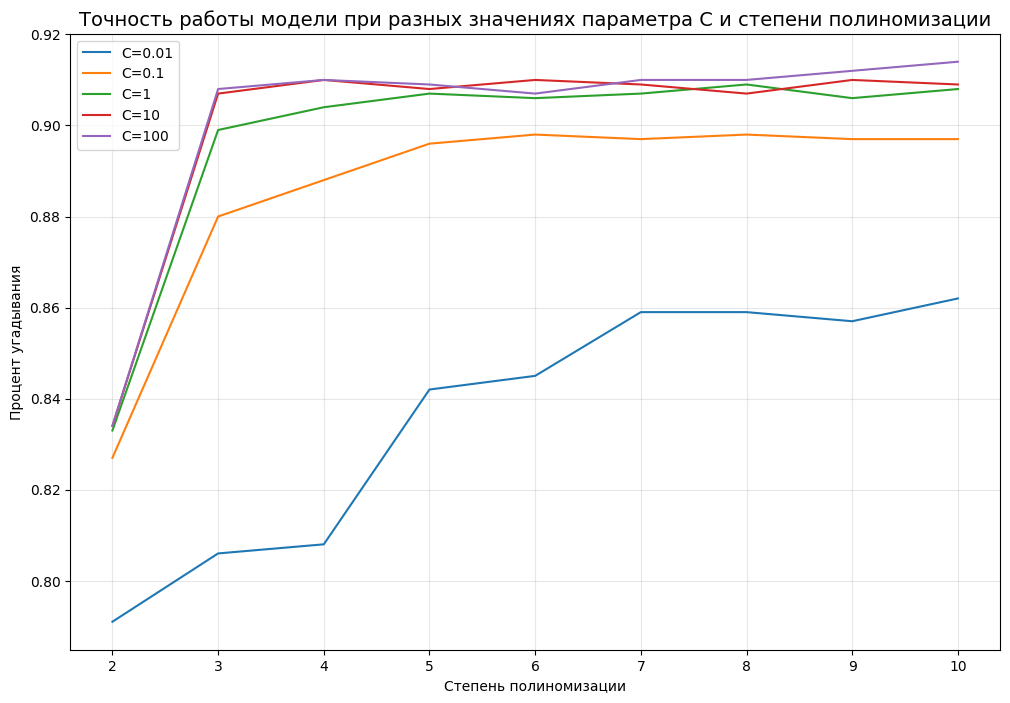

In [9]:
fig, ax = plt.subplots(figsize = (12,8))

for i in range(0,len(c)):
    ax.plot(degree_poly, value_accuracy_score_array[i], label=("C="+str(c[i])))

ax.set_title("Точность работы модели при разных значениях параметра С и степени полиномизации", fontsize=14)

ax.set_xlabel("Степень полиномизации") # Подписываем ось X
ax.set_ylabel("Процент угадывания") # Подписываем ось Y

ax.set_xticks(degree_poly)

ax.legend(loc='best') # Расположение легенды (выбирается лучшее расположение автоматически)

ax.grid(alpha = 0.3)

plt.show()

Самым оптимальным значением параметра будет `C=1` (тогда не будет переобучения (overfitting) и недообучения (underfitting), увидим это на графике) и `полином=5-ой степени` (при повышении степени полинома (больше 5) точность не значительно увеличивается, а нагрузка возрастет, так что 5-ая степень достаточно оптимальный полином для данной выборки).

#### Реализуем метод с наилучшими гиперпараметрами

In [10]:
poly = PolynomialFeatures(degree=5)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=1, max_iter=3000) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 0.907
Точность работы модели (model_logical_reg.score) = 0.907


#### Изобразим результат работы алгоритма на графике

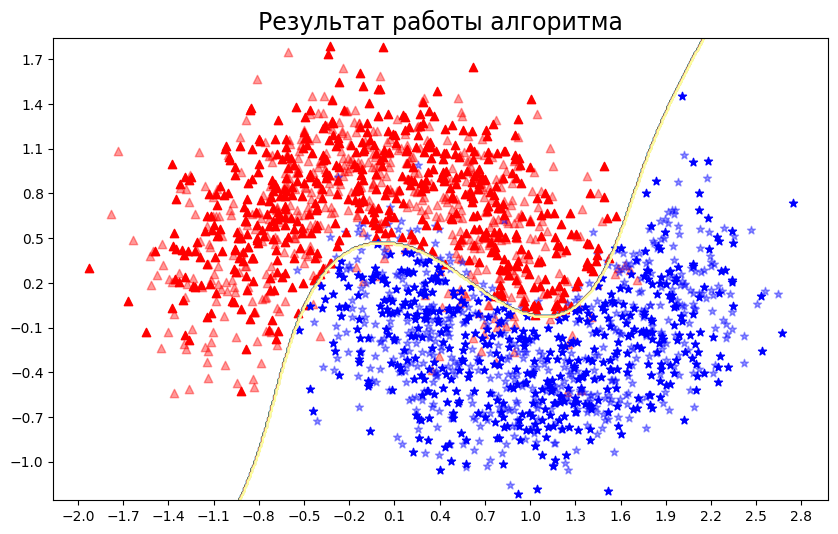

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01 ,poly_featurizer=poly)

ax.set_title("Результат работы алгоритма", fontsize=17)

ax.set_xticks(np.arange(-2, 3, 0.3))
ax.set_yticks(np.arange(-1, 2, 0.3))

plt.show()

#### Посмотрим как выглядит переобучение (overfitting) на графике. Возьмем `C=100` и `полином=10-ой степени`.

In [12]:
poly = PolynomialFeatures(degree=10)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=100, max_iter=3000) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 0.914
Точность работы модели (model_logical_reg.score) = 0.914


#### Изобразим результат работы переобученной модели на графике

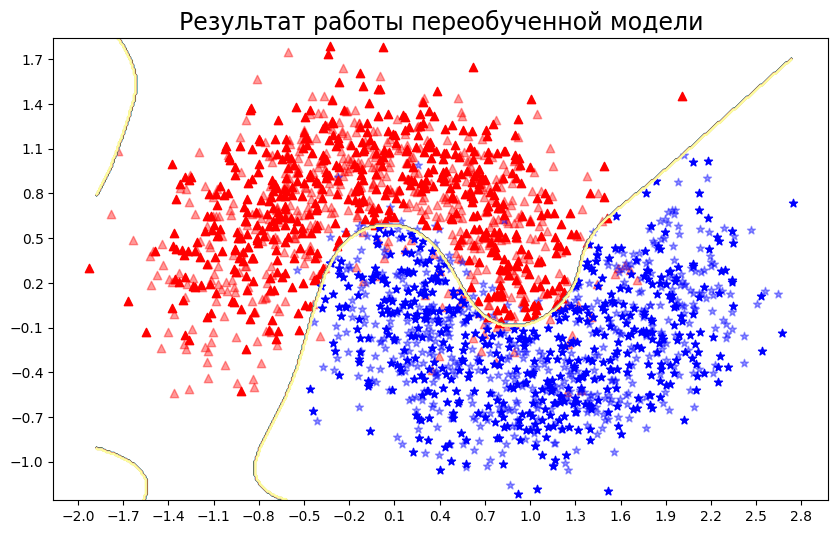

In [13]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01, poly_featurizer=poly)

ax.set_title("Результат работы переобученной модели", fontsize=17)

ax.set_xticks(np.arange(-2, 3, 0.3))
ax.set_yticks(np.arange(-1, 2, 0.3))

plt.show()

Видно, что разделяющая кривая классификатора получилась слишком извилистой. Регуляции слабая, поэтому модель переобучилась.

## Набор данных 2

In [14]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, class_sep=0.4,
                           random_state=1, n_clusters_per_class=1)

### Разделим данные на обучающую и тестовую выборку
Параметры train_test_split:
- test_size -> указывает какой % данных пойдет на тестовую выборку;
- random_state -> отвечает за перемешивание данных (параметр = 0 гарантирует воспроизводимость результата).

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#### Изобразим данные на графике.

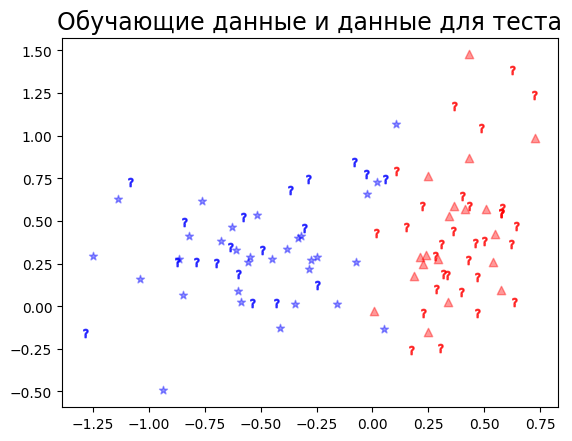

In [16]:
fig, ax = plt.subplots()

# Обучающая выборка - красные треугольники и синие звездочки

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Тестовая выборка - знаки вопроса

ax.scatter(x_test[y_test==0,0],x_test[y_test==0,1], color="r", marker="$?$", alpha=0.7)
ax.scatter(x_test[y_test==1,0],x_test[y_test==1,1], color="b", marker="$?$", alpha=0.7)

ax.set_title("Обучающие данные и данные для теста", fontsize=17)

ax.set_xticks(np.arange(-1.25, 1, 0.25))
ax.set_yticks(np.arange(-0.5, 1.75, 0.25))

plt.show()

### Реализуем метод логистической регрессии для набора данных №2

#### Реализуем метод без гиперпараметров

In [17]:
poly = PolynomialFeatures(degree=1) # Линейная модель
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=1) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 0.98
Точность работы модели (model_logical_reg.score) = 0.98


#### Изобразим результат работы алгоритма на графике

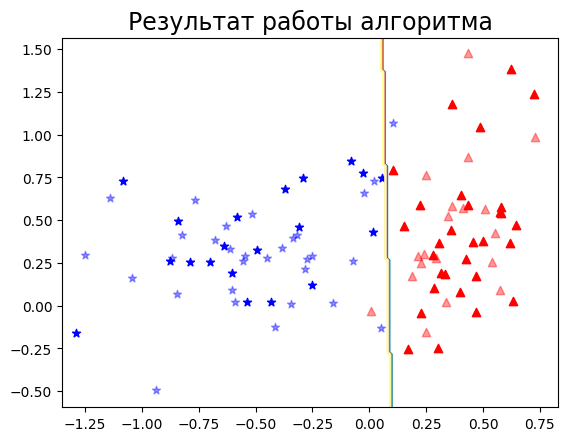

In [18]:
fig, ax = plt.subplots()

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01 ,poly_featurizer=poly)

ax.set_title("Результат работы алгоритма", fontsize=17)

ax.set_xticks(np.arange(-1.25, 1, 0.25))
ax.set_yticks(np.arange(-0.5, 1.75, 0.25))

plt.show()

**Данная выборка очень близка к линейно разделимой, поэтому, запуская алгоритм со значениями гиперпараметров по умолчанию, мы получаем очень высокую точность определения класса. Подбор гиперпараметров или поиск степени полинома, приведут лишь к тому, что наша модель будет работать корректно лишь с обучающими данными.**

## Набор данных 3

In [19]:
X, y = make_circles(n_samples=100, noise=0.2, factor=0.3, random_state=1)

### Разделим данные на обучающую и тестовую выборку
Параметры train_test_split:
- test_size -> указывает какой % данных пойдет на тестовую выборку;
- random_state -> отвечает за перемешивание данных (параметр = 0 гарантирует воспроизводимость результата).

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#### Изобразим данные на графике.

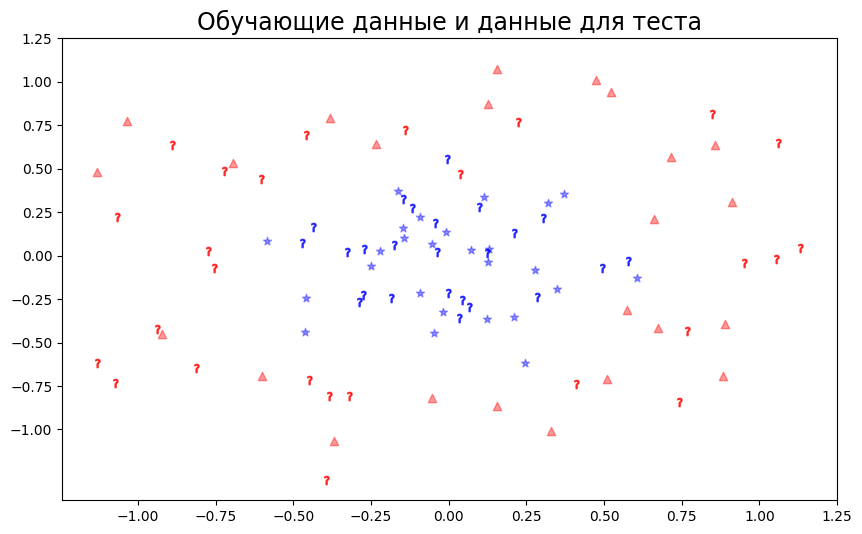

In [21]:
fig, ax = plt.subplots(figsize = (10,6))

# Обучающая выборка - красные треугольники и синие звездочки

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Тестовая выборка - знаки вопроса

ax.scatter(x_test[y_test==0,0],x_test[y_test==0,1], color="r", marker="$?$", alpha=0.7)
ax.scatter(x_test[y_test==1,0],x_test[y_test==1,1], color="b", marker="$?$", alpha=0.7)

ax.set_title("Обучающие данные и данные для теста", fontsize=17)

ax.set_xticks(np.arange(-1, 1.5, 0.25))
ax.set_yticks(np.arange(-1, 1.5, 0.25))

plt.show()

### Реализуем метод логистической регрессии для набора данных №3

#### Реализуем метод без гиперпараметров

In [22]:
poly = PolynomialFeatures(degree=1) # Линейная модель
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=1) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 0.54
Точность работы модели (model_logical_reg.score) = 0.54


#### Изобразим результат работы алгоритма на графике

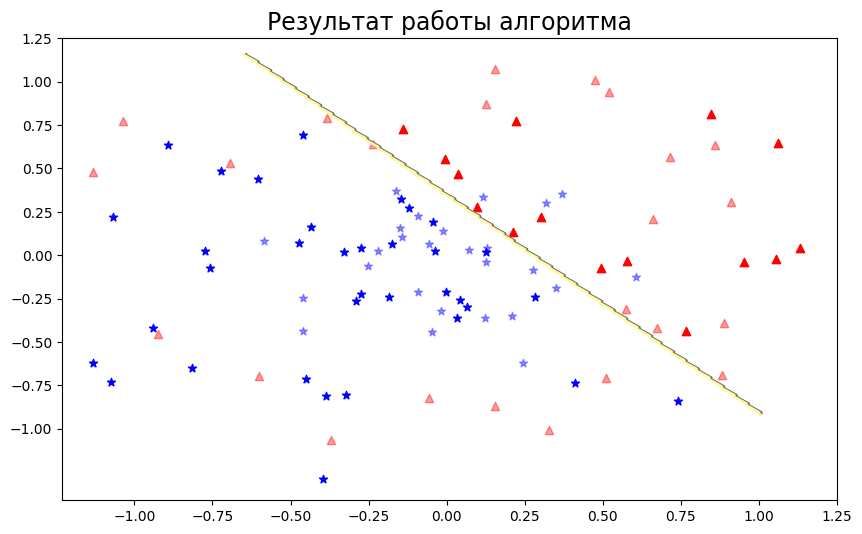

In [23]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01 ,poly_featurizer=poly)

ax.set_title("Результат работы алгоритма", fontsize=17)

ax.set_xticks(np.arange(-1, 1.5, 0.25))
ax.set_yticks(np.arange(-1, 1.5, 0.25))

plt.show()

**Очень хорошо видно, что данные совсем не линейно разделимые, поэтому необходимо задать полиномизацию, которая более точно опишет наши данные. Также посмотрим как изменение гиперпараметра регуляризации отразится на точности предсказания.**

#### Поиск наилучших параметров для метода

In [24]:
%time
value_accuracy_score_array = [[],[],[],[],[]] 

degree_poly = list(range(2,11)) # Степень полиномизации
c = [0.01, 0.1, 1, 10, 100] # Значение регуляризации

#value_accuracy_score_array[0] - c="0.01"
#value_accuracy_score_array[1] - c="0.1"
#value_accuracy_score_array[2] - c="1"
#...

#value_accuracy_score_array[0][0] - c="0.01", degree_poly = 2
#value_accuracy_score_array[0][1] - c="0.01", degree_poly = 3
#...
#value_accuracy_score_array[1][0] - c="0.1", degree_poly = 2
#value_accuracy_score_array[1][1] - c="0.1", degree_poly = 3
#...
#value_accuracy_score_array[2][0] - c="1", degree_poly = 2
#value_accuracy_score_array[2][1] - c="1", degree_poly = 3
#...

#Индексы используются для записи в value_accuracy_score_array
index_degree_polynomial = 0
index_regularization = 0

for i in c:
    index_degree_polynomial = 0
    
    for j in degree_poly:   
        poly = PolynomialFeatures(degree=j)
        x_poly_train = poly.fit_transform(x_train)
        x_poly_test = poly.fit_transform(x_test)
        
        model_logical_reg = LogisticRegression(C=i, max_iter=3000) # C = 1.0 (default=1.0)
        model_logical_reg.fit(x_poly_train, y_train)
        y_pred = model_logical_reg.predict(x_poly_test)

        value_accuracy_score=accuracy_score(y_test, y_pred)
        value_accuracy_score_array[index_regularization].append(value_accuracy_score)
        index_degree_polynomial+=1
        
    print("iteration ("+ str(index_regularization)+ "\\4)")
    index_regularization+=1  
        
print("\nc=0.01, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[0],"\n")
print("c=0.1, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[1],"\n")
print("c=1, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[2],"\n")
print("c=10, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[3],"\n")
print("c=100, degree_poly=[2..10] -> score:\n", value_accuracy_score_array[4])

CPU times: user 2 µs, sys: 9 µs, total: 11 µs
Wall time: 3.1 µs
iteration (0\4)
iteration (1\4)
iteration (2\4)
iteration (3\4)
iteration (4\4)

c=0.01, degree_poly=[2..10] -> score:
 [0.48, 0.48, 0.56, 0.54, 0.64, 0.62, 0.64, 0.66, 0.66] 

c=0.1, degree_poly=[2..10] -> score:
 [0.76, 0.76, 0.78, 0.78, 0.76, 0.76, 0.76, 0.76, 0.74] 

c=1, degree_poly=[2..10] -> score:
 [0.92, 0.92, 0.9, 0.9, 0.9, 0.9, 0.88, 0.88, 0.86] 

c=10, degree_poly=[2..10] -> score:
 [0.94, 0.94, 0.94, 0.94, 0.92, 0.92, 0.92, 0.92, 0.92] 

c=100, degree_poly=[2..10] -> score:
 [0.96, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94]


Изобразим полученный результат точности работы модели на графике, чтобы определить с каким значением параметра `c` и `степени полиномизации` модель дает наилучший результат.

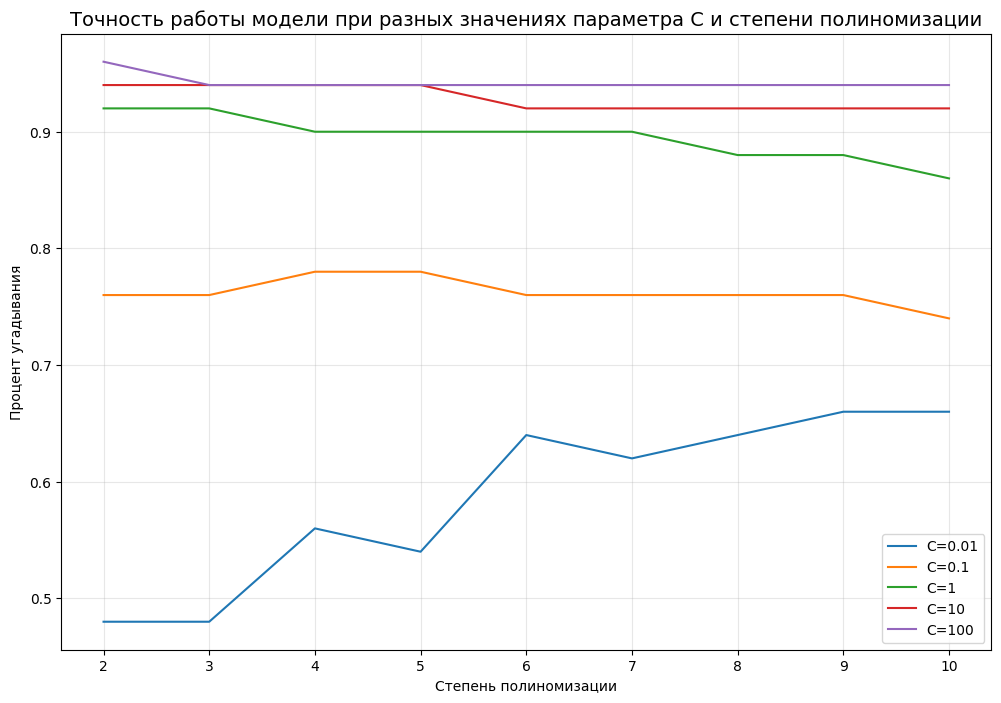

In [25]:
fig, ax = plt.subplots(figsize = (12,8))

for i in range(0,len(c)):
    ax.plot(degree_poly, value_accuracy_score_array[i], label=("C="+str(c[i])))

ax.set_title("Точность работы модели при разных значениях параметра С и степени полиномизации", fontsize=14)

ax.set_xlabel("Степень полиномизации") # Подписываем ось X
ax.set_ylabel("Процент угадывания") # Подписываем ось Y

ax.set_xticks(degree_poly)

ax.legend(loc='best') # Расположение легенды (выбирается лучшее расположение автоматически)

ax.grid(alpha = 0.3)

plt.show()

Самым оптимальным значением параметра будет `C=1` (тогда не будет переобучения (overfitting) и недообучения (underfitting), увидим это на графике) и `полином=2-ой степени` (при повышении степени полинома (больше 2) точность не значительно увеличивается, а нагрузка возрастет, так что 2-ая степень достаточно оптимальный полином для данной выборки).

#### Реализуем метод с наилучшими гиперпараметрами

In [26]:
poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=1, max_iter=3000) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 0.92
Точность работы модели (model_logical_reg.score) = 0.92


#### Изобразим результат работы алгоритма на графике

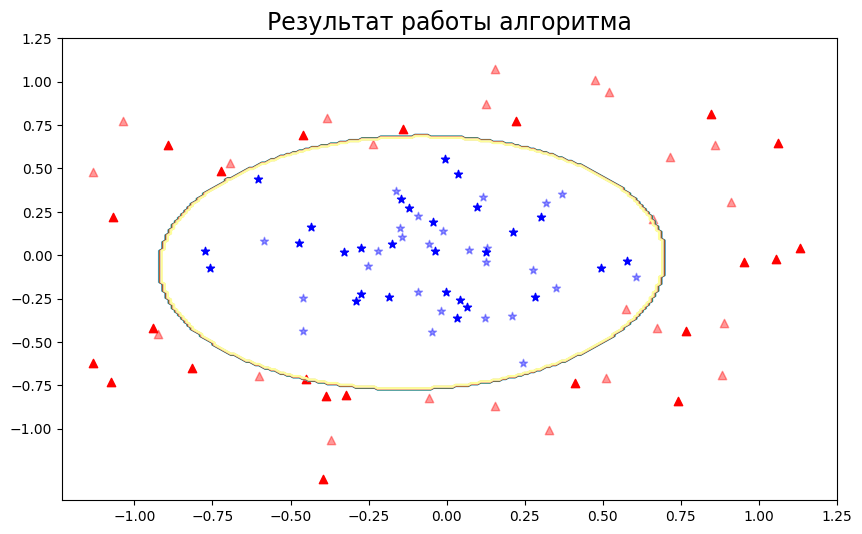

In [27]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01 ,poly_featurizer=poly)

ax.set_title("Результат работы алгоритма", fontsize=17)

ax.set_xticks(np.arange(-1, 1.5, 0.25))
ax.set_yticks(np.arange(-1, 1.5, 0.25))

plt.show()

#### Посмотрим как выглядит недообучение (underfitting) на графике. Возьмем `C=0.01` и `полинон=6-ой степени`.

In [28]:
poly = PolynomialFeatures(degree=6)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=0.01, max_iter=3000) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 0.64
Точность работы модели (model_logical_reg.score) = 0.64


#### Изобразим результат работы недообученной модели на графике

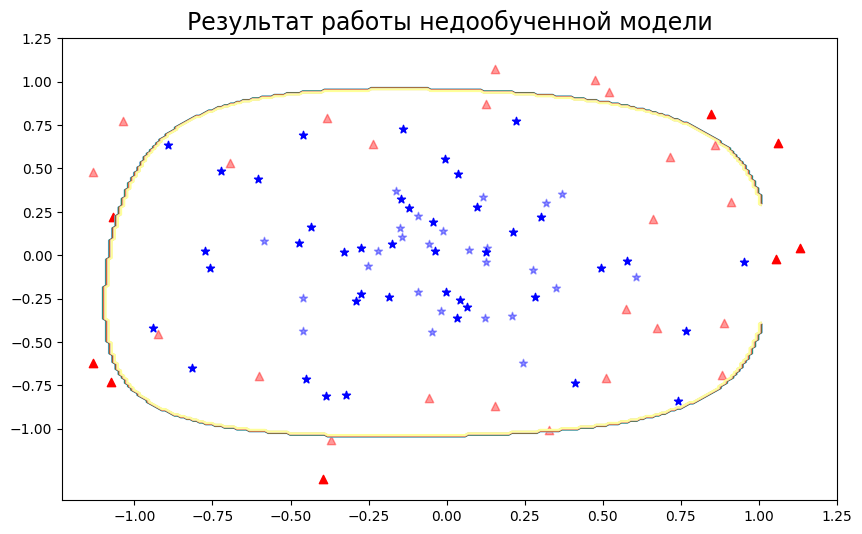

In [29]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01 ,poly_featurizer=poly)

ax.set_title("Результат работы недообученной модели", fontsize=17)

ax.set_xticks(np.arange(-1, 1.5, 0.25))
ax.set_yticks(np.arange(-1, 1.5, 0.25))

plt.show()

Видим, что регуляризация (гиперпараметр `C`) оказалась слишком сильной, и модель "недообучилась".

## Набор данных 4

In [30]:
X, y = make_blobs(n_samples=100, centers=[[4, 4], [-4, -4]], cluster_std=2, random_state=0)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X= np.dot(X, transformation)

### Разделим данные на обучающую и тестовую выборку
Параметры train_test_split:
- test_size -> указывает какой % данных пойдет на тестовую выборку;
- random_state -> отвечает за перемешивание данных (параметр = 0 гарантирует воспроизводимость результата).

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#### Изобразим данные на графике.

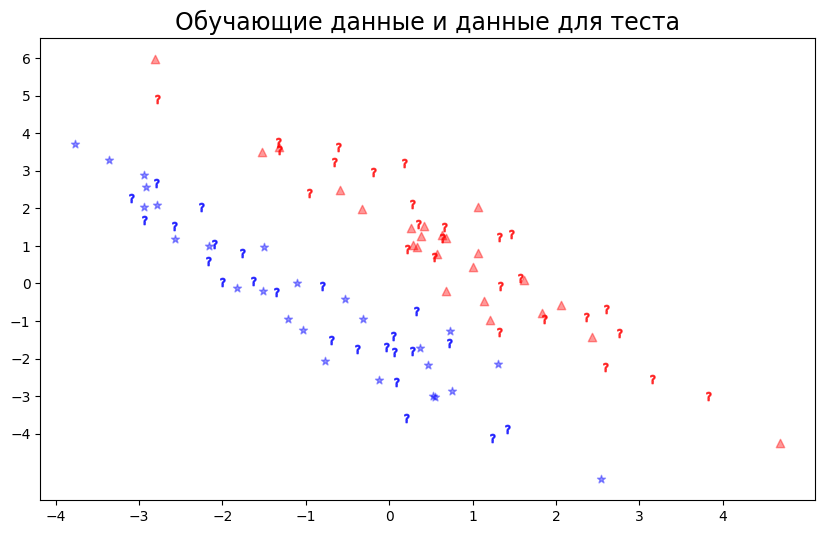

In [32]:
fig, ax = plt.subplots(figsize = (10,6))

# Обучающая выборка - красные треугольники и синие звездочки

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Тестовая выборка - знаки вопроса

ax.scatter(x_test[y_test==0,0],x_test[y_test==0,1], color="r", marker="$?$", alpha=0.7)
ax.scatter(x_test[y_test==1,0],x_test[y_test==1,1], color="b", marker="$?$", alpha=0.7)

ax.set_title("Обучающие данные и данные для теста", fontsize=17)

ax.set_xticks(np.arange(-4, 5, 1))
ax.set_yticks(np.arange(-4, 7, 1))

plt.show()

### Реализуем метод логистической регрессии для набора данных №4

#### Реализуем метод без гиперпараметров

In [33]:
poly = PolynomialFeatures(degree=1) # Линейная модель
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)

model_logical_reg = LogisticRegression(C=1) # C = 1.0 (default=1.0)
model_logical_reg.fit(x_poly_train, y_train)
y_pred = model_logical_reg.predict(x_poly_test)

print("Точность работы модели (accuracy_score) =", accuracy_score(y_test, y_pred)) 
print("Точность работы модели (model_logical_reg.score) =", model_logical_reg.score(x_poly_test, y_test))

Точность работы модели (accuracy_score) = 1.0
Точность работы модели (model_logical_reg.score) = 1.0


#### Изобразим результат работы алгоритма на графике

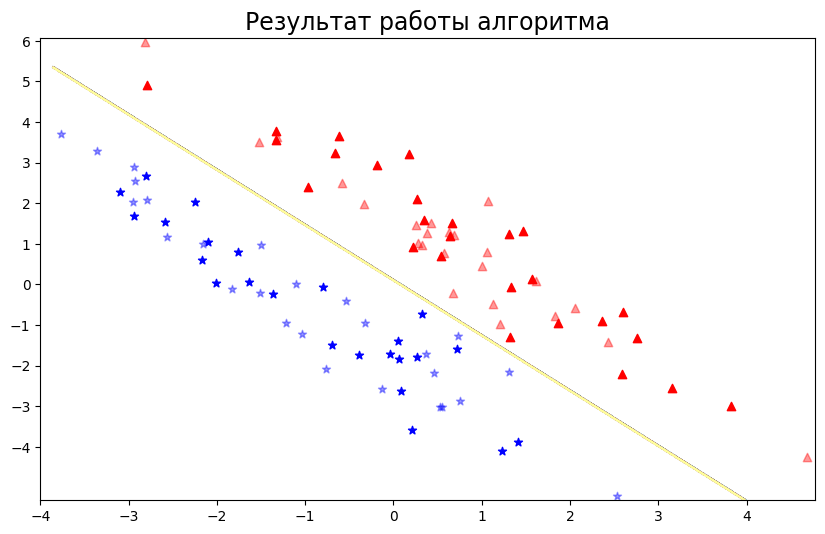

In [34]:
fig, ax = plt.subplots(figsize = (10,6))

# Thus x_train[y_train==0,0] finds all the rows of x_train that
# have a y_train value of 0 (y_train == 0), and are in the first column of x_train...

# Обучающая выборка - красные треугольники и синие звездочки (прозрачные)

ax.scatter(x_train[y_train==0,0],x_train[y_train==0,1], color="r", marker="^", alpha=0.4)
ax.scatter(x_train[y_train==1,0],x_train[y_train==1,1], color="b", marker="*", alpha=0.4)

# Результат работы алгоритма - красные треугольники и синие звездочки (не прозрачные)

ax.scatter(x_test[y_pred==0,0],x_test[y_pred==0,1], color="r", marker="^", alpha=1)
ax.scatter(x_test[y_pred==1,0],x_test[y_pred==1,1], color="b", marker="*", alpha=1)

# Разделяющая кривая классификатора

plot_boundary(model_logical_reg, x_train, y_train, grid_step=.01, poly_featurizer=poly)

ax.set_title("Результат работы алгоритма", fontsize=17)

ax.set_xticks(np.arange(-4, 5, 1))
ax.set_yticks(np.arange(-4, 7, 1))

plt.show()

**Данная выборка является линейно разделимой, поэтому запуская алгоритм со значениями гиперпараметров по умолчанию, мы получаем очень высокую точность определения класса. Нет необходимости искать значения гиперпараметров или определять степень полинома, это приведет лишь к тому, что наша модель будет работать корректно лишь с обучающими данными.**